In [1]:
import pandas as pd
import numpy as np

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Read data

In [2]:
calendar = pd.read_csv("./data/calendar.csv")
sales = pd.read_csv("./data/sales_train_evaluation.csv")
selling_prices = pd.read_csv("./data/sell_prices.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

## Clean data
* 將資料轉為可訓練用的數據
* 去除具明顯共現的特徵
* 節省數據儲存空間

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### calendar data
* 去除共線特徵
* 建立 ordinal encoding

In [4]:
def process_calendar(df):
    df = df.drop(columns=["date", "weekday", "event_type_1", "event_type_2"])
    df.d = df.d.str[2:].astype(int)
    df[['event_name_1','event_name_2']] = df[['event_name_1','event_name_2']].fillna('NA')

    # ordinal encoding
    for cat in ['event_name_1','event_name_2']:
        cat_map = {b:a+1 for a,b in enumerate(df[cat].unique())}
        df[cat] = df[cat].map(cat_map).astype('int32')    

    df = reduce_mem_usage(df,verbose=False)
    return df

In [5]:
calendar = process_calendar(calendar)

In [6]:
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


### sales data
* 由於時間跨度長達1942天, 按過往經驗要做一些過舊的資料移除, 可增加準確度和節省空間 (這邊移除1000天當例子)
* 新增未來預測用的28天欄位
* 配合資料格式 將資料resahpe成每樣物品一天一筆 
* 由於從趨勢圖可看出有7天的規律 建立一個lag 7期特徵和rooling mean來觀察這特徵的狀態

In [7]:
drop_day = [f"d_{i+1}" for i in range(1000)]
add_day = [f"d_{i}" for i in range(1942,1942+28)]
sales = sales.drop(columns=drop_day)
sales[add_day] = np.float('NaN')

In [8]:
sales = sales.melt(id_vars=["id", "item_id", "store_id", "state_id",  "cat_id", "dept_id"], var_name='d', value_name='y')
sales['d'] = sales['d'].str[2:].astype('int32')

In [9]:
%%time
sales[f'lag7'] = sales.groupby('id')['y'].shift(7).astype("float32")
sales[f'rolling_lag7_r7'] = sales.groupby('id')['lag7'].transform(lambda x: x.rolling(7).mean()).astype("float32")
sales[f'rolling_lag7_r28'] = sales.groupby('id')['lag7'].transform(lambda x: x.rolling(28).mean()).astype("float32")

CPU times: user 33min 53s, sys: 7.78 s, total: 34min 1s
Wall time: 34min 3s


In [10]:
sales

,id,item_id,store_id,state_id,cat_id,dept_id,d,y,lag7,rolling_lag7_r7,rolling_lag7_r28
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,CA_1,CA,HOBBIES,HOBBIES_1,1001,2.0,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,CA_1,CA,HOBBIES,HOBBIES_1,1001,0.0,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,CA_1,CA,HOBBIES,HOBBIES_1,1001,0.0,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,CA_1,CA,HOBBIES,HOBBIES_1,1001,0.0,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,CA_1,CA,HOBBIES,HOBBIES_1,1001,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
29544805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN
29544806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN
29544807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN
29544808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN


* 去除無'rolling_lag7_r7','rolling_lag7_r28' 資訊的歷史資料
* 獲得sales整理好的資料 對其他資料作合併

In [11]:
sales = sales[sales.d>1035]

In [12]:
sales

,id,item_id,store_id,state_id,cat_id,dept_id,d,y,lag7,rolling_lag7_r7,rolling_lag7_r28
1067150,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,CA_1,CA,HOBBIES,HOBBIES_1,1036,1.0,0.0,0.142857,0.642857
1067151,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,CA_1,CA,HOBBIES,HOBBIES_1,1036,0.0,0.0,0.142857,0.142857
1067152,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,CA_1,CA,HOBBIES,HOBBIES_1,1036,0.0,0.0,0.000000,0.000000
1067153,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,CA_1,CA,HOBBIES,HOBBIES_1,1036,3.0,3.0,2.000000,2.178571
1067154,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,CA_1,CA,HOBBIES,HOBBIES_1,1036,4.0,1.0,1.000000,0.678571
...,...,...,...,...,...,...,...,...,...,...,...
29544805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN
29544806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN
29544807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN
29544808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,WI_3,WI,FOODS,FOODS_3,1969,NaN,NaN,NaN,NaN


In [13]:
df = sales.merge(calendar, how='left', on='d')

In [14]:
df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [15]:
categorical_feature = ['item_id', 'store_id', 'state_id', 'cat_id', 'dept_id']

In [16]:
for cat in categorical_feature:
    cat_map = {b:a+1 for a,b in enumerate(df[cat].unique())}
    df[cat] = df[cat].map(cat_map).astype('float32')

In [17]:
df.head(5)

,id,item_id,store_id,state_id,cat_id,dept_id,d,y,lag7,rolling_lag7_r7,...,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,1.0,1.0,1.0,1.0,1.0,1036,1.0,0.0,0.142857,...,11344,7,11,2013,1,1,0,0,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,2.0,1.0,1.0,1.0,1.0,1036,0.0,0.0,0.142857,...,11344,7,11,2013,1,1,0,0,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,3.0,1.0,1.0,1.0,1.0,1036,0.0,0.0,0.000000,...,11344,7,11,2013,1,1,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,4.0,1.0,1.0,1.0,1.0,1036,3.0,3.0,2.000000,...,11344,7,11,2013,1,1,0,0,0,4.64
4,HOBBIES_1_005_CA_1_evaluation,5.0,1.0,1.0,1.0,1.0,1036,4.0,1.0,1.000000,...,11344,7,11,2013,1,1,0,0,0,3.08


In [18]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1330.76 Mb (38.0% reduction)


In [19]:
use_xcol = [x for x in df.columns if x not in ['id', 'd', 'y']]

### 資料分割

In [20]:
train = df[df.d <1942]
test = df[df.d >= (1942-7-28-28)]

In [21]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(train[use_xcol], 
                                                  train['y'], 
                                                  test_size=0.1, 
                                                  shuffle=True, 
                                                  random_state=54)

In [22]:
import lightgbm as lgb

lgb_train = lgb.Dataset(xtrain, label = ytrain)
lgb_valid = lgb.Dataset(xvalid, label = yvalid)

In [95]:
params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'seed': 123,
    'learning_rate' : 0.05,
    'lambda': 0.1,
    'num_leaves': 42,        
    #'device':'gpu',
    'bagging_freq' : 1,
    'sub_row' : 0.7,
    'force_row_wise' : True,
    'colsample_bytree': 0.8
}

lgb_model = lgb.train(params,
                      lgb_train, 
                      categorical_feature=categorical_feature,
                      num_boost_round = 3000, 
                      valid_sets = [lgb_valid],
                      early_stopping_rounds = 200,
                      verbose_eval = 100)

[LightGBM] [Info] Total Bins 3573
[LightGBM] [Info] Number of data points in the train set: 24861546, number of used features: 18
[LightGBM] [Info] Start training from score 0.207097
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.25341
[200]	valid_0's rmse: 2.21838
[300]	valid_0's rmse: 2.1997
[400]	valid_0's rmse: 2.18592
[500]	valid_0's rmse: 2.17487
[600]	valid_0's rmse: 2.16721
[700]	valid_0's rmse: 2.1596
[800]	valid_0's rmse: 2.15192
[900]	valid_0's rmse: 2.14514
[1000]	valid_0's rmse: 2.1406
[1100]	valid_0's rmse: 2.13737
[1200]	valid_0's rmse: 2.13356
[1300]	valid_0's rmse: 2.12981
[1400]	valid_0's rmse: 2.12667
[1500]	valid_0's rmse: 2.12403
[1600]	valid_0's rmse: 2.12143
[1700]	valid_0's rmse: 2.11812
[1800]	valid_0's rmse: 2.1156
[1900]	valid_0's rmse: 2.11349
[2000]	valid_0's rmse: 2.11162
[2100]	valid_0's rmse: 2.10985
[2200]	valid_0's rmse: 2.10831
[2300]	valid_0's rmse: 2.10677
[2400]	valid_0's rmse: 2.1055
[2500]	valid_0's rmse: 2.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

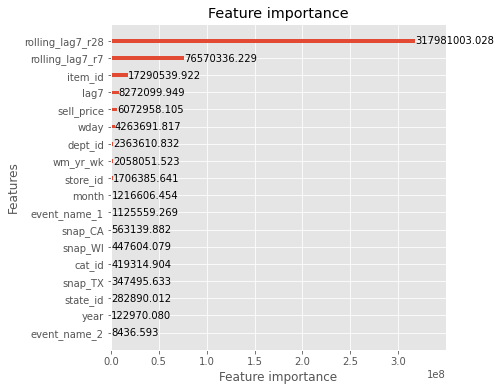

In [96]:
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(6, 6))

In [97]:
def generate_single_eval(data):
    out = data.groupby('id', sort=False).last()
    out[f'lag_7'] = data.groupby('id', sort=False)['y'].nth(-8).astype("float32")
    out[f'rolling_lag7_r7'] = data.groupby('id', sort=False)['y'].nth(-8).groupby('id', sort=False).mean().astype("float32")
    out[f'rolling_lag7_r28'] = data.groupby('id', sort=False)['y'].nth(list(range(-35, -7))).groupby('id', sort=False).mean().astype("float32")
    return out.reset_index()

In [98]:
def multi_step_pred(model,test_data,col):
    for day in range(1942, 1970):
        test_day = generate_single_eval(test[(test.d <= day) & (test.d >= day-35 )])
        test.loc[test.d == day, "y"] = model.predict(test_day[col])
    return test

In [99]:
pred = multi_step_pred(lgb_model, test, use_xcol)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [100]:
pred

,id,item_id,store_id,state_id,cat_id,dept_id,d,y,lag7,rolling_lag7_r7,...,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price
25703070,HOBBIES_1_001_CA_1_evaluation,1.0,1.0,1.0,1.0,1.0,1879,1.000000,0.0,0.714355,...,11608,3,3,2016,1,1,0,0,0,8.257812
25703071,HOBBIES_1_002_CA_1_evaluation,2.0,1.0,1.0,1.0,1.0,1879,0.000000,0.0,0.285645,...,11608,3,3,2016,1,1,0,0,0,3.970703
25703072,HOBBIES_1_003_CA_1_evaluation,3.0,1.0,1.0,1.0,1.0,1879,0.000000,0.0,0.571289,...,11608,3,3,2016,1,1,0,0,0,2.970703
25703073,HOBBIES_1_004_CA_1_evaluation,4.0,1.0,1.0,1.0,1.0,1879,4.000000,3.0,1.000000,...,11608,3,3,2016,1,1,0,0,0,4.640625
25703074,HOBBIES_1_005_CA_1_evaluation,5.0,1.0,1.0,1.0,1.0,1879,2.000000,2.0,1.286133,...,11608,3,3,2016,1,1,0,0,0,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28477655,FOODS_3_823_WI_3_evaluation,3044.0,10.0,3.0,3.0,7.0,1969,0.958496,NaN,NaN,...,11621,2,6,2016,15,5,0,0,0,2.980469
28477656,FOODS_3_824_WI_3_evaluation,3046.0,10.0,3.0,3.0,7.0,1969,0.336670,NaN,NaN,...,11621,2,6,2016,15,5,0,0,0,2.480469
28477657,FOODS_3_825_WI_3_evaluation,3048.0,10.0,3.0,3.0,7.0,1969,0.952637,NaN,NaN,...,11621,2,6,2016,15,5,0,0,0,3.980469
28477658,FOODS_3_826_WI_3_evaluation,3048.0,10.0,3.0,3.0,7.0,1969,1.583008,NaN,NaN,...,11621,2,6,2016,15,5,0,0,0,1.280273


In [103]:
tt = pred.pivot(index='id', columns='d')['y'].reset_index()
tt = tt.rename(columns={x:f'F_{i+1}' for i,x in enumerate(range(1942,1970))})
ans_col = ['id'] + [f"F_{i}" for i in range(1,29)]

In [104]:
sample_submission = sample_submission.merge(tt[ans_col],how='left',on='id')
sample_submission = sample_submission.fillna(0)
sample_submission = sample_submission.drop(columns=[f"F{i}" for i in range(1,29)]).rename(columns={f"F_{i}":f"F{i}" for i in range(1,29)  })
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,HOBBIES_1_002_CA_1_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,HOBBIES_1_003_CA_1_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,HOBBIES_1_004_CA_1_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,HOBBIES_1_005_CA_1_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.541504,0.633789,0.640137,0.520020,0.577637,0.850586,0.868652,0.687500,0.629395,...,0.767578,1.042969,1.121094,0.822266,0.773438,0.835938,0.685059,0.751465,0.960449,0.958496
60976,FOODS_3_824_WI_3_evaluation,0.271729,0.263184,0.262939,0.530273,0.294434,0.611328,0.348633,0.316650,0.304199,...,0.295410,0.394043,0.410156,0.307373,0.356445,0.349854,0.304688,0.337646,0.374512,0.336670
60977,FOODS_3_825_WI_3_evaluation,1.181641,0.591309,0.656738,0.585938,0.758789,0.760742,1.327148,0.824219,0.737793,...,0.919434,1.353516,1.490234,1.055664,0.919434,0.937500,0.730469,0.826660,1.095703,0.952637
60978,FOODS_3_826_WI_3_evaluation,2.974609,4.054688,1.581055,1.270508,1.366211,1.586914,1.903320,1.617188,2.263672,...,1.495117,2.062500,2.193359,1.536133,1.574219,1.638672,1.375000,1.499023,1.903320,1.583008


In [106]:
sample_submission.to_csv('out_2.csv',index=0)